<a href="https://colab.research.google.com/github/kwanglo/mge51101-20195171/blob/master/assignment/GRU_kwanglo_20195171.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

Mon May 18 07:14:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

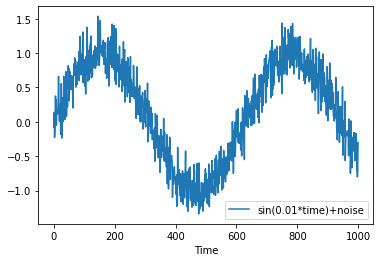

In [2]:
T = 1000
time = torch.arange(0.0, T)
X = torch.sin(0.01 * time) + 0.2 * torch.randn(T)
plt.plot(time.numpy(), X.numpy(), label="sin(0.01*time)+noise");
plt.legend();
plt.xlabel("Time");
plt.show()

In [0]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# Hyperparameter
batch_size, train_number = 16, 600

# timestamp
tau = 4
# AR Model needs tau inputs: shape is (996, 4)
# Create same size input with above
features = torch.zeros((T-tau, tau)) 

for i in range(tau):
    features[:, i] = X[i:(T-tau + i)]
labels = X[tau:] # shape is (996, )

time_len = features.size()[1] #length of feature to put in RNN(coordinate for char_len in sample code)

# Create same size set for estimate
estimate = torch.zeros((T-tau,tau))
features.size()
features[1]

# Prepare DataLoader
train_data = TensorDataset(features[:train_number, :], labels[:train_number])
test_data = TensorDataset(features[train_number:, :], labels[train_number:])

In [0]:
import torch.nn as nn

# Parameter Initialization
def init_weight(map_):
    if type(map_) == nn.Linear:
        torch.nn.init.xavier_uniform_(map_.weight)

# Build GRU module
class gruRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(gruRNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)        
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, inputs, hidden):
        
        inputs = inputs.view(1, 1, -1) # (batch_size, seq_size, n_hidden)
        hidden = hidden.view(self.num_layers, 1, -1)

        output, hidden = self.gru(inputs, hidden)
        output = self.fc(output)

        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
# Hyperparameters
n_hidden = time_len - 1 #to fit new input len
lr = 0.01
epochs = 200

model = gruRNN(time_len, n_hidden, 1, time_len)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
#Training Code
for epoch in range(epochs):
    model.zero_grad()
    running_loss = 0
    hidden = model.initHidden()

    for idx in range(features.size()[0]-1):
        inputs = features[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        target = features[idx+1]
        loss = criterion(output.view(-1),target.view(-1))
        running_loss += loss

    running_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("loss: {:.5f}".format(running_loss.data))

loss: 1097.40247
loss: 46.72525


torch.Size([996, 4])

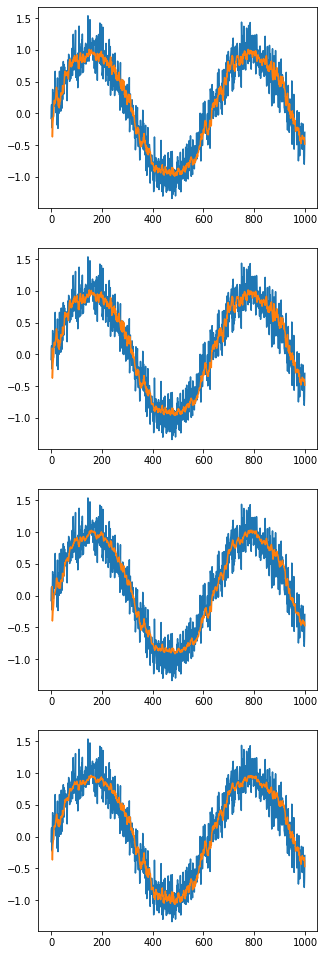

In [13]:
# Plot Results
estimate[0] = features[0]
for idx in range(features.size()[0]-1):
        inputs = features[idx:idx+1,:].reshape(1, 1, -1)
        output, hidden = model(inputs, hidden) 
        estimate[idx+1] = output

fig = plt.figure(figsize=(5, 17))
plt.subplot(411)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimate[:,0].detach().numpy(), label='Estimate');
plt.subplot(412)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimate[:,1].detach().numpy(), label='Estimate');
plt.subplot(413)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimate[:,2].detach().numpy(), label='Estimate');
plt.subplot(414)
plt.plot(time.numpy(), X.numpy(), label='GT');
plt.plot(time[tau:].numpy(), estimate[:,3].detach().numpy(), label='Estimate');
estimate.size()